(tfq)=

# Cirq & TFQ

## Введение

[Cirq](https://quantumai.google/cirq) -- это библиотека для работы с квантовыми компьютерами и симуляторами компании _Google_. В рамках темы квантового машинного обучения нам также интересен фреймворк [Tensorflow Quantum](https://www.tensorflow.org/quantum/overview) или сокращенно `TFQ`. Это высокоуровневая библиотека, которая содержит готовые функции для квантового и гибридного машинного обучения. В качестве системы автоматического дифференцирования, а также для построения гибридных квантово-классических нейронных сетей там используется библиотека [Tensorflow](https://www.tensorflow.org/overview/).

```{warning}
Во всех дальнейших лекциях мы будем использовать в основном библиотеку `PennyLane`, так что данная лекция исключительно обзорная и факультативная. В ней мы посмотрим несколько примеров _end2end_ обучения квантовых схем на `TFQ` без детального объяснения теории и вообще того, что происходит. Основная цель данной лекции -- исключительно обзор еще одного инструмента, а не изучение QML! Заинтересованный читатель может вернуться к этому обзору после изучения глав про [VQC](vqc), [Градиенты](gradients) и **Квантовые нейросети**.
```

## Работа с кубитами

### Импорты и схема

Для начала импортируем `cirq`.

In [1]:
import cirq

`Cirq` рассчитан на работу с квантовым компьютером от компании _Google_, который представляет собой решетку кубитов. Например, вот так выглядит решетка кубитов квантового компьютера `Sycamore`:

```{figure} /_static/progblock/tfq/sycamore.png
:width: 400px
:name: sycamore_lattice

Изображение из {cite}`sycamore`
```

Поэтому в нем все строится вокруг работы с решеткой кубитов -- объектом `cirq.GridQubit`. Давайте создадим кубит на решетке, который имеет координаты $(0, 0)$:

In [2]:
qubit = cirq.GridQubit(0, 0)

Следующей важной концепцией в `Cirq` является непосредственно квантовая схема. Давайте создадим схему, которая переводит кубит в суперпозицию состояний $\ket{0}$ и $\ket{1}$ и измеряет его:

In [3]:
circuit = cirq.Circuit()
circuit.append(cirq.H(qubit))
circuit.append(cirq.measure(qubit))
print(circuit)

(0, 0): ───H───M───


### Запуск и симуляция

Теперь создадим квантовый симулятор, который посчитает нам результат этой простой схемы на классическом компьютере:

In [4]:
sim = cirq.Simulator()

Как мы знаем, результат измерения такой схемы равен 50% для состояния $\ket{0}$, то есть если мы будем сэмплировать, то должны получать $\sim 0.5$. Проверим это с разным числом сэмплов:

In [5]:
print("5 сэмплов:")
print(sim.sample(circuit, repetitions=5).mean())
print("\n100 сэмплов:")
print(sim.sample(circuit, repetitions=100).mean())
print("\n1000 сэмплов:")
print(sim.sample(circuit, repetitions=1000).mean())

5 сэмплов:
(0, 0)    0.2
dtype: float64

100 сэмплов:
(0, 0)    0.54
dtype: float64

1000 сэмплов:
(0, 0)    0.495
dtype: float64


```{note}
Метод `sim.sample` озвращает хорошо знакомый всем специалистам в области Data Science объект `pandas.DataFrame`. Для тех, кто слышит про такой впервые рекомендуем обратиться к вводным лекциям про `Python` и классическое машинное обучение.
```

Также у нас есть опция запустить схему через метод `run`. Может показаться, что это то же самое, но на самом деле в отличие от `sample` метод `run` возвращает результат в несколько ином виде, а еще он позволяет запускать программу на реальном квантовом компьютере `Goolge` или их новых квантовых симуляторах на TPU:

In [6]:
print(sim.run(circuit, repetitions=25))

(0, 0)=0101101000010111101010011


Тут мы просто видим последовательность наших измерений.

## Квантовое машинное обучение

### Импорты

Мы будем использовать `Tensorflow` и `Tensorflow Quantum`.

In [7]:
import tensorflow as tf
import tensorflow_quantum as tfq

### Задача

Давайте попробуем решить игрушечную задачку классификации простой гибридной квантово-классической нейронной сетью. У нас будет один квантовый слой и один классический слой. В качестве задачи сгенерируем простенький набор данных, используя рутины `scikit-learn`. Сразу переведем входящие признаки в диапазон от нуля до $\pi$.

In [8]:
from sklearn.datasets import make_classification
import numpy as np

x, y = make_classification(n_samples=50, n_features=2, n_informative=2,
                           random_state=42, n_redundant=0)

def normalize(x):
    x_min = x.min()
    x_max = x.max()

    return np.pi * (x - x_min) / (x_max - x_min)

x[:, 0] = normalize(x[:, 0])
x[:, 1] = normalize(x[:, 1])

Посмотрим на эти данные:

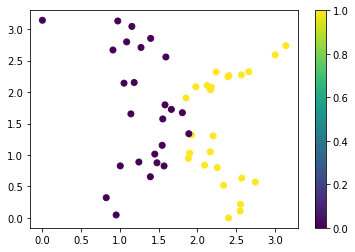

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
cb = plt.scatter(x[:, 0], x[:, 1], c=y)
plt.colorbar(cb)
plt.show()

### Кубиты

`Tensorflow Quantum` позволяет "превращать" параметризированные схемы `Cirq` в слои нейронных сетей `Tensorflow`. Но для начала нам все равно потребуется схема. Давайте объявим пару кубитов.

In [10]:
qubits = [cirq.GridQubit(0, 0), cirq.GridQubit(0, 1)]
print(qubits)

[cirq.GridQubit(0, 0), cirq.GridQubit(0, 1)]


### Входной слой нейронной сети

Определим входной слой, который будет кодировать наши классические данные в квантовые. Сразу закодируем данные. Так как `Tensorflow` работает с тензорами, то нам необходимо будет преобразовать схемы в тензор. Для этого есть специальная функция `convert_to_tensor`.

In [11]:
def data2circuit(x):
    input_circuit = cirq.Circuit()

    input_circuit.append(cirq.Ry(rads=x[0]).on(qubits[0]))
    input_circuit.append(cirq.Ry(rads=x[1]).on(qubits[1]))

    return input_circuit

x_input = tfq.convert_to_tensor([data2circuit(xi) for xi in x])

### Слой из параметризованной схемы

Для создания параметризованных схем в `Tensorflow Quantum` используются символы из библиотеки символьных вычислений [`sympy`](https://www.sympy.org/en/index.html). Давайте объявим несколько параметров и создадим схему:

In [12]:
from sympy import symbols

params = symbols("w1, w2, w3, w4")

trainable_circuit = cirq.Circuit()

trainable_circuit.append(cirq.H.on(qubits[0]))
trainable_circuit.append(cirq.H.on(qubits[1]))
trainable_circuit.append(cirq.Ry(rads=params[0]).on(qubits[0]))
trainable_circuit.append(cirq.Ry(rads=params[1]).on(qubits[1]))

trainable_circuit.append(cirq.CNOT.on(qubits[0], qubits[1]))

trainable_circuit.append(cirq.H.on(qubits[0]))
trainable_circuit.append(cirq.H.on(qubits[1]))
trainable_circuit.append(cirq.Rx(rads=params[2]).on(qubits[0]))
trainable_circuit.append(cirq.Rx(rads=params[3]).on(qubits[1]))

trainable_circuit.append(cirq.CNOT.on(qubits[0], qubits[1]))

print(trainable_circuit)

(0, 0): ───H───Ry(w1)───@───H───Rx(w3)───@───
                        │                │
(0, 1): ───H───Ry(w2)───X───H───Rx(w4)───X───


### Наблюдаемые

В качестве операторов, которые мы будем измерять, воспользуемся парой $\hat{XY}$ и $\hat{YX}$ для наших кубитов:

In [13]:
ops = [cirq.X.on(qubits[0]) * cirq.Y.on(qubits[1]), cirq.Y.on(qubits[0]) * cirq.X.on(qubits[1])]

### Гибридная нейронная сеть

Теперь воспользуемся классическим `Tensorflow`, чтобы объявить и скомпилировать нашу нейронную сеть, предварительно добавив в нее один классический слой.

- зафиксируем случайный генератор

In [14]:
tf.random.set_seed(42)

- входной тензор -- это в нашем случае тензор типа `string`, так как это квантовые схемы

In [15]:
cirq_inputs = tf.keras.Input(shape=(), dtype=tf.dtypes.string)

- квантовый слой

In [16]:
quantum_layer = tfq.layers.PQC(
    trainable_circuit,
    ops
)(cirq_inputs)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


- классический слой и выходной слой

In [17]:
dense_layer = tf.keras.layers.Dense(2, activation="relu")(quantum_layer)
output_layer = tf.keras.layers.Dense(1, activation="sigmoid")(dense_layer)

- компилируем модель и смотрим, что получилось. И сразу указываем метрики, которые хотим отслеживать

In [18]:
model = tf.keras.Model(inputs=cirq_inputs, outputs=output_layer)
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(),
        tf.keras.metrics.BinaryCrossentropy(),
    ]
)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
pqc (PQC)                    (None, 2)                 4         
_________________________________________________________________
dense (Dense)                (None, 2)                 6         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3         
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________


### Предсказания со случайной инициализацией

Наша нейросеть имеет случайные начальные параметры. Давайте посмотрим, что она предсказывает до обучения:

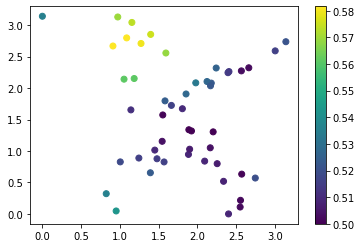

In [19]:
preds = model(x_input).numpy()

plt.figure(figsize=(6, 4))
cb = plt.scatter(x[:, 0], x[:, 1], c=preds)
plt.colorbar(cb)
plt.show()

### Обучение сети

- запустим обучение

In [20]:
model.fit(x=x_input, y=y, epochs=200, verbose=0)

- визуализируем логи обучения

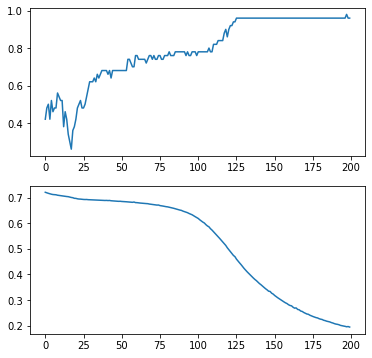

In [21]:
f, ax = plt.subplots(2, figsize=(6, 6))
ax[0].plot(model.history.history["binary_accuracy"])
ax[1].plot(model.history.history["binary_crossentropy"])
plt.show()

- визуализируем предсказания

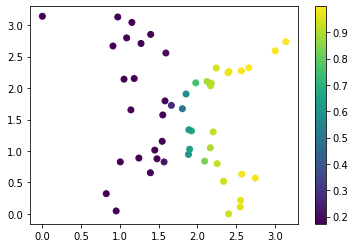

In [22]:
preds_after_training = model(x_input).numpy()
plt.figure(figsize=(6, 4))
cb = plt.scatter(x[:, 0], x[:, 1], c=preds_after_training)
plt.colorbar(cb)
plt.show()

## Заключение

В данной лекции мы познакомились с фреймворком `Tensorflow Quantum`. Это достаточно мощный инструмент, особенно в связке с `Tensorflow`, так как позволяет использовать большое число готовых методов `Tensorflow` и различных расширений. Тем не менее, для целей обучения `Tensorflow Quantum` кажется не лучшим выбором, так как имеет много неочевидного синтаксиса и предполагает, как минимум, среднего знания `Tensorflow`. Во всех дальнейших лекциях мы будем использовать в основном библиотеку `PennyLane`.